In [ ]:
# import statements
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import pyarrow as pa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install datasets transformers huggingface_hub
!pip install evaluate
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()
!pip install tqdm


In [ ]:
# read in data
df = pd.read_csv("https://raw.githubusercontent.com/arjundevireddy/DataSets/main/Tweets.csv")

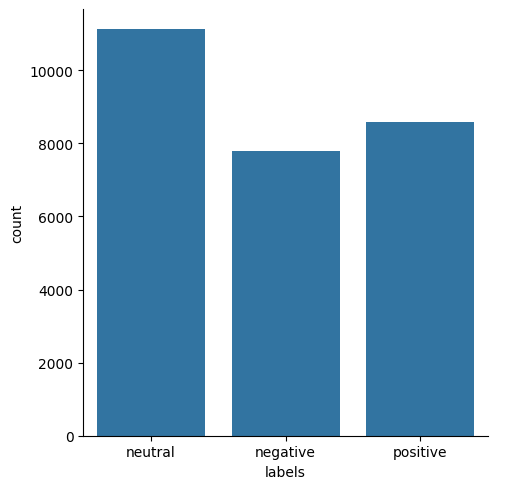

In [ ]:
# create a categorical plot for the sentiment distribution
graph = sns.catplot(x = 'labels', kind = "count", data = df)

In [ ]:
#edit column names so they work with pytorch
df.rename(columns={'sentiment': 'labels'}, inplace=True)

# impute missing values
df['text'] = df['text'].fillna('')
# map categorical variables to integers

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['labels'] = df['labels'].map(label_mapping)
df = df[['text', 'labels']]

#split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# create custom class to convert dataframe to pytorch dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        labels = self.dataframe.iloc[idx]['labels']
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        sample = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'labels': torch.tensor(labels)}
        return sample

In [ ]:
# get distilbert tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
# Define DistilBERT as our base model:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define maximum sequence length
max_length = 100

# Create custom datasets
train_dataset = CustomDataset(train_df, tokenizer, max_length)
val_dataset = CustomDataset(val_df, tokenizer, max_length)


In [ ]:
# Create PyTorch data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# get optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
# get scheduler for model
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
# evaluate model accuracy on validation data before fine-tuning
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.30962343096234307}

The model peformed poorly before fine tuning the accuracy was less than 33% percent for classification of three labels, which is worse than random guessing. Likely since the model is a lighter model comared to larger models such as roberta and bert, it has not likely seen the type of twitter data or sentiments that I am trying to classify.

In [ ]:
# fine-tune the model on training data
from tqdm import tqdm
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


  1%|          | 15/2061 [02:51<6:29:09, 11.41s/it]

 87%|████████▋ | 1787/2061 [07:35<01:11,  3.84it/s]

In [ ]:
# evaluate model accuracy on validation data after fine-tuning
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.7882481353465527}

After fine tuning the model the performance increased significantly. This is even though the model had to be trained in batches and the number of epochs was low due to the long time that the model took to train. I tried changing the number of epochs and incraeasing and deceasing the learning rate, but since the training time was so long I wasn't able to tune the hyperparameters as well as I would have liked. In the future I would like to try to improve the model on better hardware locally rather than using google colab.